In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

In [2]:
#random seed for reproducibility
torch.manual_seed(42)

In [3]:
#check for gpu availablity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df= pd.read_csv('/content/fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [5]:
df.shape

(6000, 785)

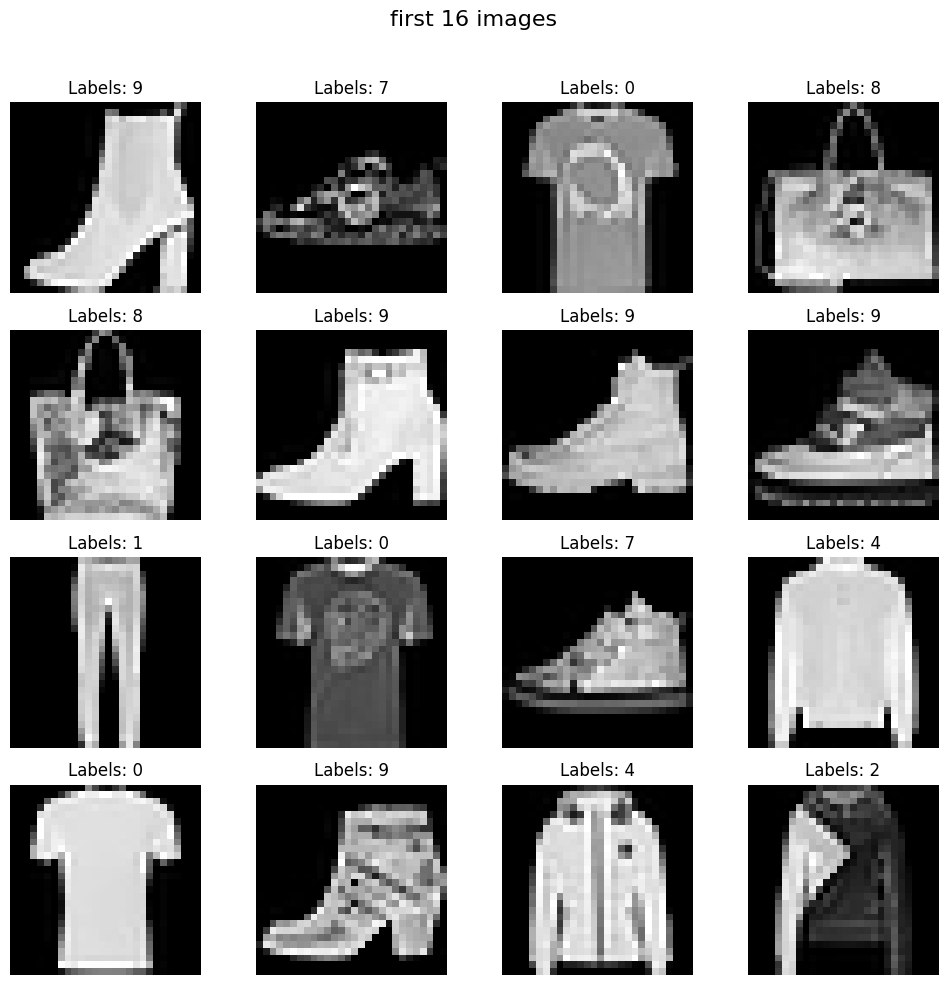

In [6]:
#create 4*4 grid of images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

#plot first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i,1:].values.reshape(28,28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Labels: {df.iloc[i,0]}")

plt.tight_layout(rect=[0 ,0 ,1 , 0.96])#adjust layout to fit the title
plt.show()

In [7]:
x = df.iloc[:, 1:].values
y= df.iloc[:, 0].values

In [8]:
x

array([[  0,   0,   0, ..., 165,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [10]:
#transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


In [11]:
from PIL import Image
import numpy as np
#create dataset class

class CustomDataset(Dataset):

  def __init__(self, features, labels, transforms):
    self.features = features
    self.labels = labels
    self.transforms = transforms
  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    #reshape (28,28)
    image = self.features[index].reshape(28,28)

    #change datatype to np.uint8
    image = image.astype(np.uint8)

    #image into 3 channels
    image = np.stack((image,)*3, axis=-1)

    #convert to PIL image
    image = Image.fromarray(image)

    #apply transformations
    image = self.transforms(image)

    return image, torch.tensor(self.labels[index], dtype=torch.long)


In [12]:

#create train dataset
train_dataset = CustomDataset(x_train, y_train, transforms = custom_transform)

In [13]:
#create test dataset
test_dataset = CustomDataset(x_test, y_test, transforms = custom_transform)

In [14]:
test_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [16]:
#fetch the pretrained model
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [18]:
for params in vgg16.features.parameters():
  params.requires_grad = False

In [19]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [20]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
learning_rate = 0.0001
epochs = 10

In [22]:

# optimizer selection
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [ ]:

#training loop
for epoch in range (epochs):
  total_epoch_loss = 0.0

  for batch_features, batch_labels in train_loader:

    #move dataset to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    #reset the gradients to zero
    optimizer.zero_grad()

    #forward pass
    outputs = vgg16(batch_features)

    #loss calculation
    loss = criterion(outputs, batch_labels)

    #backward pass
    loss.backward()

    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")


Epoch [1/10], Average Loss: 0.0033
Epoch [2/10], Average Loss: 0.0019
Epoch [3/10], Average Loss: 0.0014


In [25]:
#model evaluation
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
#evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    #move dataset to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)

    total +=batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

  accuracy = correct/total
  print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 90.08%


In [27]:
#evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    #move dataset to gpu
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    outputs = vgg16(batch_features)
    _, predicted = torch.max(outputs, 1)

    total +=batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

  accuracy = correct/total
  print(f"Train Accuracy: {accuracy*100:.2f}%")

Train Accuracy: 100.00%
